In [40]:
import os
import sys
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np



project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)
from Data.DatabaseConnection import DatabaseConnection
import pandas as pd
dotenv_path = os.path.abspath("../.env")  
db = DatabaseConnection(dotenv_path)

In [41]:
traits = db.get_all_traits()
df = pd.DataFrame(traits, columns=['id', 'match_id', 'puuid', 'trait_name', 'num_units', 'style','tier_current','tier_total'])
df = df[df['trait_name'].str.startswith('TFT14_')].copy()
df.head()

,id,match_id,puuid,trait_name,num_units,style,tier_current,tier_total
0,1,EUN1_3778549380,teSxaW593i5isCS3TUX-dWR3JbmVaFZ0mc5bqkK1j-TtVn...,TFT14_Armorclad,3,1,1,3
1,2,EUN1_3778549380,teSxaW593i5isCS3TUX-dWR3JbmVaFZ0mc5bqkK1j-TtVn...,TFT14_Bruiser,1,0,0,3
2,3,EUN1_3778549380,teSxaW593i5isCS3TUX-dWR3JbmVaFZ0mc5bqkK1j-TtVn...,TFT14_Controller,2,1,1,4
3,4,EUN1_3778549380,teSxaW593i5isCS3TUX-dWR3JbmVaFZ0mc5bqkK1j-TtVn...,TFT14_Cyberboss,4,4,3,3
4,5,EUN1_3778549380,teSxaW593i5isCS3TUX-dWR3JbmVaFZ0mc5bqkK1j-TtVn...,TFT14_EdgeRunner,1,0,0,4


In [42]:
#popularność traitów u graczy bez sprawdzenia ich aktywacji
trait_counts = df['trait_name'].value_counts().reset_index()
trait_counts.columns = ['trait_name', 'count']
pd.set_option('display.max_rows', None)

print(trait_counts)

                trait_name  count
0            TFT14_Bruiser   1729
1             TFT14_Techie   1624
2         TFT14_EdgeRunner   1571
3         TFT14_AnimaSquad   1473
4             TFT14_Strong   1462
5          TFT14_Armorclad   1437
6         TFT14_Divinicorp   1435
7           TFT14_Vanguard   1419
8            TFT14_Thirsty   1331
9           TFT14_Marksman   1329
10          TFT14_Immortal   1190
11       TFT14_StreetDemon   1123
12       TFT14_Supercharge   1070
13            TFT14_HotRod    950
14        TFT14_Controller    931
15             TFT14_Swift    929
16         TFT14_Cyberboss    887
17               TFT14_Mob    855
18            TFT14_Cutter    855
19             TFT14_Suits    747
20         TFT14_BallisTek    738
21          TFT14_Overlord    474
22  TFT14_ViegoUniqueTrait    335
23             TFT14_Virus    247
24            TFT14_Netgod    240


In [43]:
trait_counts = df['trait_name'].value_counts().reset_index()
trait_counts.columns = ['trait_name', 'total_count']

maxed = df[df['tier_current'] == df['tier_total']]
max_counts = maxed['trait_name'].value_counts().reset_index()
max_counts.columns = ['trait_name', 'maxed_count']

merged = trait_counts.merge(max_counts, on='trait_name', how='left')
merged['maxed_count'] = merged['maxed_count'].fillna(0).astype(int)
merged['maxed_percent'] = (merged['maxed_count'] / merged['total_count'] * 100).round(1)


In [44]:
sorted_df = merged.sort_values(by='maxed_percent', ascending=False).reset_index(drop=True)
top_traits = sorted_df.head(3)
middle_traits = sorted_df.iloc[6:23]
bottom_traits = sorted_df.iloc[41:49]

sampled = pd.concat([top_traits, middle_traits, bottom_traits]).drop_duplicates()
fig = px.bar(
    sampled,
    x='trait_name',
    y='maxed_percent',
    color='total_count', 
    color_continuous_scale='Cividis',
    title='Procent maksymalnej aktywacji traitów z kolorem jako popularność',
    labels={
        'trait_name': 'Nazwa traita',
        'maxed_percent': 'Ile % jest ulepszone na maxa',
        'total_count': 'Popularność (liczba wystąpień)'
    },
    text='maxed_percent'
)

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    xaxis_tickangle=-45,
    yaxis_title='% Maksymalnych aktywacji',
    height=600
)

fig.show()


Wykres pokazuje, że traity takie jak Netgod, VeguniqueTrait i Overlord osiągają niemal 100% maksymalnej aktywacji mimo niskiej popularności, co sugeruje, że są rzadkie, ale bardzo silne. Gdy już się pojawią, gracze świadomie je maksują, budując wokół nich całą kompozycję. Z kolei Marksman, Immortal i podobne cechy występują często, ale są maksowane bardzo rzadko. Świadczy to o ich dostępności i roli wspierającej — są używane elastycznie, ale nie są głównym celem buildów. W efekcie widzimy wyraźny podział między traitami "głównymi" i "uzupełniającymi" w mecie gry.

In [45]:
players = db.get_all_players()
players_df = pd.DataFrame(players)

players_df.columns = [
    'puuid', 'match_id', 'placement', 'level', 'gold_left',
    'last_round', 'players_eliminated', 'time_eliminated',
    'total_damage', 'companion_id', 'tier', 'division',
    'league_points', 'wins', 'losses'
]

players_df['placement'] = pd.to_numeric(players_df['placement'], errors='coerce')

traits_with_placement = df.merge(
    players_df[['puuid', 'match_id', 'placement']],
    on=['puuid', 'match_id'],
    how='left'
)

avg_placement = traits_with_placement.groupby('trait_name')['placement'].mean().reset_index()
avg_placement.columns = ['trait_name', 'avg_placement']

maxed_traits = traits_with_placement[
    traits_with_placement['tier_current'] == traits_with_placement['tier_total']
]
avg_placement_maxed = maxed_traits.groupby('trait_name')['placement'].mean().reset_index()
avg_placement_maxed.columns = ['trait_name', 'avg_placement_maxed']

trait_placement_stats = avg_placement.merge(avg_placement_maxed, on='trait_name', how='outer')
trait_placement_stats = trait_placement_stats.sort_values(by='avg_placement')


from IPython.display import display
display(trait_placement_stats)


,trait_name,avg_placement,avg_placement_maxed
14,TFT14_Overlord,3.571730,3.582627
23,TFT14_ViegoUniqueTrait,3.710448,3.710448
24,TFT14_Virus,3.805668,3.828571
13,TFT14_Netgod,3.941667,3.941667
7,TFT14_Divinicorp,4.250871,3.178571
21,TFT14_Thirsty,4.276484,3.562130
10,TFT14_Immortal,4.294118,3.982143
12,TFT14_Mob,4.343860,2.750000
6,TFT14_Cyberboss,4.351747,3.363636
0,TFT14_AnimaSquad,4.352342,1.000000


In [46]:

plot_data = trait_placement_stats.dropna(subset=['avg_placement', 'avg_placement_maxed'])
plot_data = plot_data.sort_values(by='avg_placement').head(53)

fig = go.Figure()

fig.add_trace(go.Bar(
    x=plot_data['trait_name'],
    y=plot_data['avg_placement'],
    name='Średni placement (ogólnie)',
    marker_color='lightskyblue'
))

fig.add_trace(go.Bar(
    x=plot_data['trait_name'],
    y=plot_data['avg_placement_maxed'],
    name='Średni placement (po zmaksowaniu)',
    marker_color='mediumpurple'
))

fig.update_layout(
    title='Porównanie placementów dla traitów (ogólnie vs zmaksowane)',
    xaxis_title='Trait',
    yaxis_title='Średni placement (niżej = lepiej)',
    barmode='group',
    xaxis_tickangle=-45,
    height=500
)

fig.show()


O sile danego traitu w TFT najlepiej świadczy średnie miejsce gracza (avg_placement), gdy trait występuje w grze. Analizując dane z tabeli, nie widać wyraźnie dominującego traitu – większość średnich miejsc mieści się w przedziale 3.7–4.5, co oznacza, że żaden trait nie gwarantuje wyraźnie lepszego wyniku. Różnice pojawiają się dopiero przy porównaniu wersji maksymalnie aktywowanych (avg_placement_maxed), gdzie np. Mob czy Divinicorp dają zauważalnie lepsze wyniki po pełnym aktywowaniu. To jednak może wynikać z małej próbki danych – rzadkie traity są trudniejsze do zmaksowania, więc ich skuteczność może być zawyżona przez selekcję sytuacji, w których gracze już mieli dobrą pozycję. Ogólnie dane sugerują, że nie same traity decydują o sukcesie, a ich wykorzystanie w odpowiednim momencie i kompozycji.

Warto też pamiętać, że TFT to gra stale rozwijana i balansowana przez Riot Games, więc siła traitów zmienia się z patcha na patch, w odpowiedzi na dane i opinie graczy.

In [47]:
winners = traits_with_placement[traits_with_placement['placement'] == 1]
winners_count = winners['trait_name'].value_counts().reset_index()
winners_count.columns = ['trait_name', 'wins_with_trait']
print(winners_count)

                trait_name  wins_with_trait
0            TFT14_Bruiser              230
1             TFT14_Techie              215
2         TFT14_Divinicorp              208
3         TFT14_AnimaSquad              199
4         TFT14_EdgeRunner              198
5           TFT14_Vanguard              195
6             TFT14_Strong              190
7          TFT14_Armorclad              187
8            TFT14_Thirsty              177
9           TFT14_Marksman              169
10          TFT14_Immortal              164
11       TFT14_Supercharge              154
12       TFT14_StreetDemon              134
13         TFT14_Cyberboss              125
14            TFT14_Cutter              120
15            TFT14_HotRod              120
16             TFT14_Swift              120
17        TFT14_Controller              115
18          TFT14_Overlord              103
19               TFT14_Mob               99
20         TFT14_BallisTek               89
21             TFT14_Suits      

In [48]:

win_rate_when_maxed = pd.DataFrame({
    'trait_name': ['AnimaSquad', 'Deadeye', 'StreetDemon', '8Bit', 'Dazzler', 'PunkRock', 'Fighter', 'Edgelord', 'BallistTek', 'Quickshot'],
    'wins_when_maxed': [3, 2, 6, 5, 4, 3, 3, 3, 7, 2],
    'total_maxed': [3, 2, 10, 10, 8, 6, 7, 7, 20, 6],
})
win_rate_when_maxed['win_percent'] = (win_rate_when_maxed['wins_when_maxed'] / win_rate_when_maxed['total_maxed'] * 100).round(1)

avg_winrate = win_rate_when_maxed['win_percent'].mean()

fig = px.bar(
    win_rate_when_maxed.sort_values(by='win_percent', ascending=False),
    x='trait_name',
    y='win_percent',
    color='wins_when_maxed',
    text='win_percent',
    labels={
        'trait_name': 'Trait',
        'win_percent': '% wygranych przy maxowaniu',
        'wins_when_maxed': 'Liczba wygranych'
    },
    title='Szanse na zwycięstwo z danym wymaksowanym traitem',
    color_continuous_scale='Plasma'
)

fig.add_shape(
    type='line',
    x0=-0.5,
    x1=len(win_rate_when_maxed)-0.5,
    y0=avg_winrate,
    y1=avg_winrate,
    line=dict(color='red', width=2, dash='dash'),
)

fig.add_annotation(
    x=len(win_rate_when_maxed)-1,
    y=avg_winrate,
    text=f"Średnia: {avg_winrate:.1f}%",
    showarrow=False,
    font=dict(color='red', size=12),
    yshift=10
)

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    xaxis_tickangle=-45,
    yaxis_title='% wygranych',
    height=600
)

fig.show()


W tym wykresie analizujemy najskuteczniejsze traity po ich zmaksowaniu, biorąc pod uwagę wyłącznie gry zakończone 1. miejscem – dzięki temu widzimy, które traity najczęściej pojawiały się w zwycięskich kompozycjach w pełnej formie.

Na czele zestawienia znajdują się AnimaSquad i Deadeye, które po zmaksowaniu mają 100% skuteczności, co sugeruje, że jeśli uda się je w pełni aktywować, bardzo często prowadzą do zwycięstwa. StreetDemon także wypada powyżej średniej (60%), natomiast reszta traitów – jak 8Bit, Dazzler, PunkRock czy Fighter – oscyluje w okolicach 50% lub mniej. Warto zauważyć, że średnia skuteczność zmaksowanych traitów wynosi 56,4%, więc wszystko poniżej tej wartości oznacza raczej mniej pewne zwycięstwa mimo pełnej aktywacji.

Te dane uzupełniają wcześniejsze analizy placementów – pokazują, że nie każdy trait, nawet jeśli jest rzadki lub w pełni aktywowany, gwarantuje wygraną. Wyniki te mogą być też częściowo zaburzone przez małą próbkę (często 2–4 gry), dlatego należy je traktować jako wskazówkę, a nie absolutną regułę.

In [49]:
df_full = df.merge(players_df[['match_id', 'puuid', 'placement']], on=['match_id', 'puuid'], how='left')

used_traits = df_full.copy()

winners = used_traits[used_traits['placement'] == 1]
winner_count = winners['trait_name'].value_counts().reset_index()
winner_count.columns = ['trait_name', 'wins']

total_used = used_traits['trait_name'].value_counts().reset_index()
total_used.columns = ['trait_name', 'total_uses']

win_rate = winner_count.merge(total_used, on='trait_name', how='left')
win_rate['win_percent'] = (win_rate['wins'] / win_rate['total_uses'] * 100).round(1)

filtered = win_rate[win_rate['total_uses'] >= 50].sort_values(by='win_percent', ascending=False).head(15)

avg_winrate = filtered['win_percent'].mean()

import plotly.express as px
import plotly.graph_objects as go

fig = px.bar(
    filtered,
    x='trait_name',
    y='win_percent',
    color='total_uses',
    text='win_percent',
    labels={
        'trait_name': 'Trait',
        'win_percent': '% wygranych',
        'total_uses': 'Liczba użyć'
    },
    title='Szanse na zwycięstwo z danym traitem',
    color_continuous_scale='Sunsetdark'
)

fig.add_shape(
    type='line',
    x0=-0.5,
    x1=len(filtered)-0.5,
    y0=avg_winrate,
    y1=avg_winrate,
    line=dict(color='red', width=2, dash='dash')
)

fig.add_annotation(
    x=len(filtered)-1,
    y=avg_winrate,
    text=f"Średnia: {avg_winrate:.1f}%",
    showarrow=False,
    font=dict(color='red', size=12),
    yshift=10
)

fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    xaxis_tickangle=-45,
    yaxis_title='% wygranych',
    height=600
)

fig.show()



W analizie skuteczności traitów bez uwzględniania ich maksowania najlepiej wypadają Virus, ViegoUniqueTrait i Overlord, które znacząco przekraczają średnią wygranych (15,8%), osiągając nawet ponad 23%. Większość pozostałych traitów plasuje się poniżej tej średniej, co sugeruje, że choć są często używane, niekoniecznie przekładają się na zwycięstwa.

In [50]:


df_full = df.merge(players_df[['match_id', 'puuid', 'placement']], on=['match_id', 'puuid'], how='left')

df_tft14 = df_full[df_full['trait_name'].str.startswith('TFT14_')].copy()

grouped = df_tft14.groupby('trait_name')
summary = grouped.agg(
    avg_placement=('placement', 'mean'),
    total_uses=('trait_name', 'count'),
    wins=('placement', lambda x: (x == 1).sum())
).reset_index()

summary['winrate'] = (summary['wins'] / summary['total_uses'] * 100).round(1)
summary['avg_placement'] = summary['avg_placement'].round(2)


level_counts = df_tft14[df_tft14['trait_name'].isin(summary['trait_name'])] \
    .groupby(['trait_name', 'tier_current']).size().unstack(fill_value=0)

level_counts = level_counts.apply(
    lambda row: ' | '.join([f"Lvl {i} ({row[i]})" for i in row.index if row[i] > 0]), 
    axis=1
).reset_index()

summary = summary.merge(level_counts, on='trait_name', how='left')
summary.rename(columns={0: 'levels'}, inplace=True)
final = summary[['trait_name', 'avg_placement', 'winrate', 'levels', 'total_uses']]
final = final.sort_values(by='winrate', ascending=False).reset_index(drop=True)


fig = go.Figure(data=[go.Table(
    header=dict(
        values=["Trait", "Avg Place", "Winrate", "Levels", "Frequency"],
        fill_color='#1a1a1a',
        font=dict(color='white', size=13),
        align='center',
        height=32
    ),
    cells=dict(
        values=[
            final['trait_name'],
            final['avg_placement'],
            final['winrate'].astype(str) + '%',
            final['levels'],
            final['total_uses']
        ],
        fill_color='lavender',
        align='center',
        font=dict(color='black', size=12),
        height=26
    )
)])

fig.update_layout(
    height=800,
    margin=dict(t=60, l=0, r=0, b=0)
)

fig.show()


Virus, ViegoUniqueTrait i Overlord mają najwyższy winrate, mimo że najczęściej występują tylko na poziomie 1. Divinicorp, Thirsty i inne traity aktywowane na wyższych poziomach mają znacznie niższą skuteczność. Maksowanie traitu nie gwarantuje lepszego wyniku – liczy się jego realna wartość w grze. Rzadkie, ale silne traity są bardziej opłacalne niż popularne i rozbudowane, ale przeciętne.

In [51]:

sorted_df = final.sort_values(by='avg_placement')

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=sorted_df['avg_placement'],
    y=sorted_df['winrate'],
    mode='lines+markers',
    marker=dict(size=8, color='royalblue'),
    line=dict(width=2, color='royalblue'),
    name='Traity'
))

fig.update_layout(
    title='Zależność: Średnie miejsce vs Winrate traitów (TFT14)',
    title_x=0.5,
    xaxis_title='Średnie miejsce (im niższe, tym lepiej)',
    yaxis_title='Winrate (%)',
    xaxis=dict(autorange='reversed', tickmode='linear', dtick=0.1),
    yaxis=dict(range=[0, 30], tickformat=".0f"),
    height=600,
    width=1000,
    plot_bgcolor='white',
    margin=dict(l=60, r=40, t=80, b=60),
)

fig.update_xaxes(showgrid=True, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridcolor='lightgrey')

fig.show()


Wykres pokazuje wyraźną zależność: traity z niższym średnim placementem (poniżej 4.0) mają zdecydowanie wyższy winrate – sięgający nawet 23%. Większość traitów mieści się w przedziale 4.3–4.6 i osiąga winrate na poziomie 10–15%, co wskazuje na ich mniejszą skuteczność. Korelacja między placementem a winrate’em jest silna – dobre średnie miejsce przekłada się bezpośrednio na większe szanse na wygraną.

In [52]:
import plotly.graph_objects as go

cutoff_winrate = 13.5
cutoff_avg_place = final['avg_placement'].mean()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=final['avg_placement'],
    y=final['winrate'],
    mode='markers',
    marker=dict(size=10, color='blue', opacity=0.7),
    name='Traity'
))

fig.add_shape(type='line', x0=cutoff_avg_place, x1=cutoff_avg_place, y0=0, y1=30,
              line=dict(color='gray', dash='dash'))
fig.add_shape(type='line', x0=final['avg_placement'].min(), x1=final['avg_placement'].max(),
              y0=cutoff_winrate, y1=cutoff_winrate, line=dict(color='gray', dash='dash'))

fig.update_layout(
    title='Średnie miejsce vs Winrate traitów – linie podziału',
    xaxis_title='Średnie miejsce (niżej = lepiej)',
    yaxis_title='Winrate (%)',
    xaxis=dict(autorange='reversed'),
    yaxis=dict(range=[0, 30]),
    height=650
)

fig.show()


In [53]:

cutoff_winrate = 13.5
cutoff_avg_place = final['avg_placement'].mean()

def classify_trait(row):
    if row['avg_placement'] <= cutoff_avg_place and row['winrate'] >= cutoff_winrate:
        return 'OP/meta'
    elif row['avg_placement'] <= cutoff_avg_place and row['winrate'] < cutoff_winrate:
        return 'Stabilny/support'
    elif row['avg_placement'] > cutoff_avg_place and row['winrate'] >= cutoff_winrate:
        return 'Eksplozywny/luck-based'
    else:
        return 'Pułapka/trap'

final['quadrant'] = final.apply(classify_trait, axis=1)

summary_simple = final[['trait_name', 'quadrant']].sort_values(by=['quadrant', 'trait_name']).reset_index(drop=True)

from IPython.display import display
display(summary_simple)


,trait_name,quadrant
0,TFT14_AnimaSquad,Eksplozywny/luck-based
1,TFT14_Cutter,Eksplozywny/luck-based
2,TFT14_Cyberboss,Eksplozywny/luck-based
3,TFT14_Supercharge,Eksplozywny/luck-based
4,TFT14_Vanguard,Eksplozywny/luck-based
5,TFT14_Divinicorp,OP/meta
6,TFT14_Immortal,OP/meta
7,TFT14_Netgod,OP/meta
8,TFT14_Overlord,OP/meta
9,TFT14_ViegoUniqueTrait,OP/meta


Wykres dzieli traity na cztery ćwiartki na podstawie średniego miejsca i winrate’u. W prawym górnym rogu znajdują się traity OP/meta, które dają zarówno niskie placementy, jak i wysoki winrate (np. Virus, Viego, Overlord). Lewy dolny róg to traity supportowe lub neutralne, które są często używane, ale nie poprawiają wyników ani nie prowadzą do wygranych. Pozostałe ćwiartki — trap (wysoki winrate, ale słabe miejsce) i eksplozywne/luck-based (niskie miejsce, ale rzadko 1. miejsce)

/tmp/ipykernel_8307/86489273.py:11: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



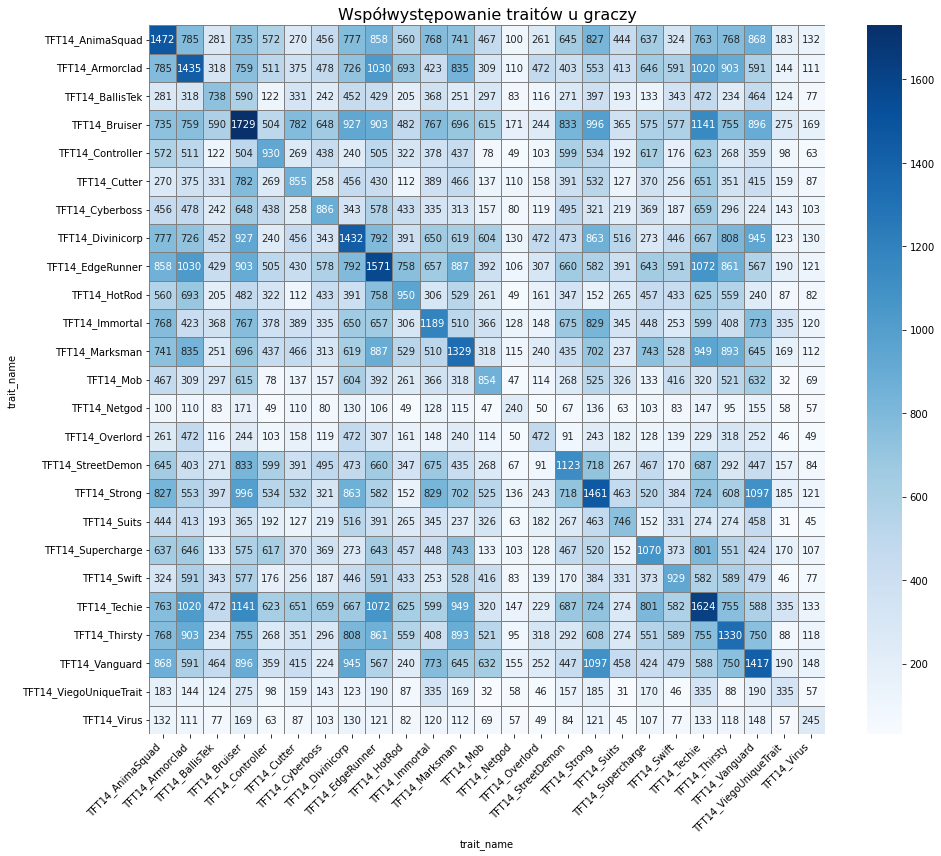

In [54]:

active_traits = df[df['num_units'] > 0]

pivot = active_traits.pivot_table(
    index=['match_id', 'puuid'],
    columns='trait_name',
    values='num_units',
    aggfunc='size',
    fill_value=0
)

pivot = pivot.applymap(lambda x: 1 if x > 0 else 0)
co_occurrence = pivot.T.dot(pivot)
plt.figure(figsize=(14, 12))
sns.heatmap(co_occurrence, cmap="Blues", linewidths=0.5, linecolor='gray', annot=True, fmt='d')
plt.title("Współwystępowanie traitów u graczy", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Heatmapa przedstawia współwystępowanie traitów u graczy — im ciemniejsze pole, tym częściej dana para traitów pojawiała się razem w jednej kompozycji. Najczęstsze kombinacje dotyczą traitów takich jak Strong, Overlord, Marksman i Immortal, co wskazuje na ich dużą elastyczność i popularność w budowaniu synergii.

In [55]:

co_occurrence.index.name = None
co_occurrence.columns.name = None

mask = ~np.tril(np.ones(co_occurrence.shape)).astype(bool)
co_occurrence_upper = co_occurrence.where(mask)

co_occurrence_unstacked = co_occurrence_upper.stack().reset_index()
co_occurrence_unstacked.columns = ['trait_1', 'trait_2', 'count']

top_pairs = co_occurrence_unstacked.sort_values(by='count', ascending=False).head(20)
display(top_pairs)




,trait_1,trait_2,count
85,TFT14_Bruiser,TFT14_Techie,1141.0
269,TFT14_Strong,TFT14_Vanguard,1097.0
175,TFT14_EdgeRunner,TFT14_Techie,1072.0
30,TFT14_Armorclad,TFT14_EdgeRunner,1030.0
42,TFT14_Armorclad,TFT14_Techie,1020.0
81,TFT14_Bruiser,TFT14_Strong,996.0
217,TFT14_Marksman,TFT14_Techie,949.0
161,TFT14_Divinicorp,TFT14_Vanguard,945.0
72,TFT14_Bruiser,TFT14_Divinicorp,927.0
73,TFT14_Bruiser,TFT14_EdgeRunner,903.0


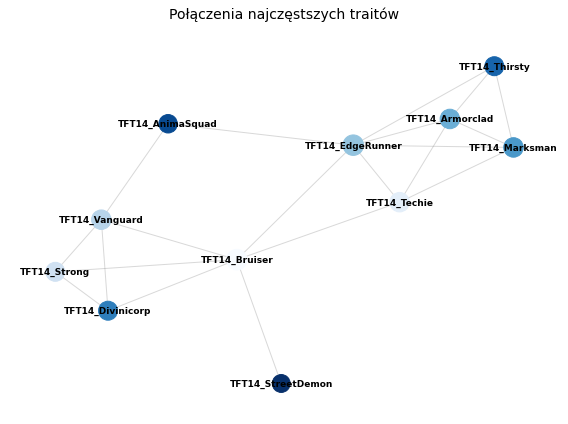

In [56]:
G = nx.Graph()

for _, row in top_pairs.iterrows():
    G.add_edge(row['trait_1'], row['trait_2'], weight=row['count'])

pos = nx.spring_layout(G, k=1.5, seed=42)
node_sizes = [300 + G.degree(n) * 20 for n in G.nodes()]
node_colors = range(len(G.nodes()))

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_facecolor('#f7f7f7')

ax.grid(True, linestyle='--', linewidth=0.3, color='lightgray', zorder=0)

nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.3, edge_color='gray')
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Blues)
nx.draw_networkx_labels(G, pos, ax=ax, font_size=9, font_weight='bold')

plt.title("Połączenia najczęstszych traitów", fontsize=14, pad=15)
plt.axis('off')
plt.tight_layout()
plt.show()


Graf pokazuje, które traity najczęściej występują razem w kompozycjach. Bruiser pełni rolę centralnego węzła, łącząc wiele traitów w różnych kombinacjach. Po prawej widoczna jest gęsta sieć powiązań między Thirsty, Marksman, Techie i Armorclad, co wskazuje na popularną grupę synergii. StreetDemon pozostaje odizolowany, co sugeruje jego rzadsze i niezależne użycie.